In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as mtri

from scipy import stats
from scipy.special import gammaln, psi
from scipy.optimize import minimize

np.set_printoptions(precision=4, suppress=True)

# Reproducibility
rng = np.random.default_rng(0)

# Quick/slow toggle (mirrors patterns used elsewhere in this repo)
FAST_RUN = True
N_SAMPLES = 30_000 if FAST_RUN else 300_000
GRID_N = 35 if FAST_RUN else 90

plt.rcParams.update({
    "figure.figsize": (9, 4.5),
    "axes.grid": True,
})


In [2]:
def validate_alpha(alpha: np.ndarray) -> np.ndarray:
    '''Validate Dirichlet parameters (all strictly positive).'''
    alpha = np.asarray(alpha, dtype=float)
    if alpha.ndim != 1:
        raise ValueError(f"alpha must be 1D, got shape={alpha.shape}")
    if alpha.size < 2:
        raise ValueError("Dirichlet requires K>=2 parameters")
    if np.any(alpha <= 0):
        raise ValueError("All alpha_i must be > 0")
    return alpha


def validate_simplex(X: np.ndarray, *, atol: float = 1e-10, allow_zeros: bool = True) -> np.ndarray:
    '''Validate points on the probability simplex (rows sum to 1).'''
    X = np.asarray(X, dtype=float)
    if X.ndim == 1:
        X = X[None, :]
    if X.ndim != 2:
        raise ValueError(f"X must be 1D or 2D, got shape={X.shape}")
    if np.any(X < 0):
        raise ValueError("Simplex components must be >= 0")
    if not allow_zeros and np.any(X <= 0):
        raise ValueError("All simplex components must be > 0 for log-likelihood computations")
    row_sums = X.sum(axis=1)
    if not np.allclose(row_sums, 1.0, atol=atol):
        raise ValueError("Each row of X must sum to 1")
    return X


def dirichlet_logpdf_numpy(X: np.ndarray, alpha: np.ndarray) -> np.ndarray:
    '''Dirichlet log-PDF implemented with NumPy + SciPy special functions.

    Notes:
    - Supports X as shape (K,) or (N, K).
    - Works on the boundary too (x_i=0), returning +/-inf where appropriate.
    '''
    alpha = validate_alpha(alpha)
    X = validate_simplex(X, allow_zeros=True)

    log_norm = gammaln(alpha.sum()) - gammaln(alpha).sum()
    with np.errstate(divide="ignore", invalid="ignore"):
        log_x = np.log(X)
    return log_norm + ((alpha - 1.0) * log_x).sum(axis=1)


def sample_dirichlet_numpy(alpha: np.ndarray, *, size: int, rng: np.random.Generator) -> np.ndarray:
    '''NumPy-only sampler via Gamma normalization.'''
    alpha = validate_alpha(alpha)
    y = rng.gamma(shape=alpha, scale=1.0, size=(size, alpha.size))
    return y / y.sum(axis=1, keepdims=True)


def dirichlet_mean(alpha: np.ndarray) -> np.ndarray:
    alpha = validate_alpha(alpha)
    return alpha / alpha.sum()


def dirichlet_cov(alpha: np.ndarray) -> np.ndarray:
    alpha = validate_alpha(alpha)
    a0 = alpha.sum()
    cov = -np.outer(alpha, alpha) / (a0**2 * (a0 + 1.0))
    np.fill_diagonal(cov, alpha * (a0 - alpha) / (a0**2 * (a0 + 1.0)))
    return cov


def beta_skewness(a: float, b: float) -> float:
    # Standardized third central moment of Beta(a, b)
    return 2 * (b - a) * np.sqrt(a + b + 1) / ((a + b + 2) * np.sqrt(a * b))


def beta_excess_kurtosis(a: float, b: float) -> float:
    # Excess kurtosis (kurtosis minus 3) of Beta(a, b)
    num = 6 * ((a - b) ** 2 * (a + b + 1) - a * b * (a + b + 2))
    den = a * b * (a + b + 2) * (a + b + 3)
    return num / den


def dirichlet_entropy(alpha: np.ndarray) -> float:
    '''Differential entropy H(X) in nats.'''
    alpha = validate_alpha(alpha)
    a0 = alpha.sum()
    k = alpha.size
    log_B = gammaln(alpha).sum() - gammaln(a0)
    return log_B + (a0 - k) * psi(a0) - ((alpha - 1.0) * psi(alpha)).sum()


SQRT3 = float(np.sqrt(3))


def simplex3_grid(n: int, *, min_component: float = 0.0) -> np.ndarray:
    '''Grid of points on the 2-simplex for K=3.

    Returns an array of shape (M, 3) with entries in [0,1] summing to 1.
    '''
    pts = []
    for i in range(n + 1):
        for j in range(n + 1 - i):
            k = n - i - j
            x = np.array([i, j, k], dtype=float) / n
            if x.min() < min_component:
                continue
            pts.append(x)
    return np.vstack(pts)


def simplex3_to_xy(X: np.ndarray) -> np.ndarray:
    '''Map (x1,x2,x3) on the simplex to 2D coordinates inside an equilateral triangle.'''
    X = np.asarray(X, dtype=float)
    if X.ndim == 1:
        X = X[None, :]
    # vertices: e1=(0,0), e2=(1,0), e3=(1/2, sqrt(3)/2)
    x = X[:, 1] + 0.5 * X[:, 2]
    y = (SQRT3 / 2.0) * X[:, 2]
    return np.column_stack([x, y])


def plot_simplex3_outline(ax: plt.Axes) -> None:
    tri = np.array([[0.0, 0.0], [1.0, 0.0], [0.5, SQRT3 / 2.0], [0.0, 0.0]])
    ax.plot(tri[:, 0], tri[:, 1], color="black", lw=1.2)
    ax.set_aspect("equal")
    ax.set_xticks([])
    ax.set_yticks([])
    ax.grid(False)


def plot_dirichlet_simplex3(alpha: np.ndarray, *, ax: plt.Axes, grid_n: int, min_component: float) -> plt.cm.ScalarMappable:
    pts = simplex3_grid(grid_n, min_component=min_component)
    xy = simplex3_to_xy(pts)
    tri = mtri.Triangulation(xy[:, 0], xy[:, 1])
    logpdf = dirichlet_logpdf_numpy(pts, alpha)
    contour = ax.tricontourf(tri, logpdf, levels=35, cmap="viridis")
    plot_simplex3_outline(ax)
    return contour


def dirichlet_fit_mle(X: np.ndarray, *, alpha_init: np.ndarray | None = None) -> tuple[np.ndarray, object]:
    '''Fit alpha by maximum likelihood.

    SciPy's `scipy.stats.dirichlet` does not provide `.fit()` (as of SciPy 1.15),
    so we optimize the log-likelihood ourselves.

    We optimize over theta = log(alpha) to enforce alpha_i > 0.
    '''
    X = validate_simplex(X, allow_zeros=False)
    n, k = X.shape
    sum_log_x = np.log(X).sum(axis=0)

    if alpha_init is None:
        # Method-of-moments-inspired initialization
        mean = X.mean(axis=0)
        var = X.var(axis=0, ddof=1)
        eps = 1e-8
        a0_est = np.mean(mean * (1.0 - mean) / np.maximum(var, eps) - 1.0)
        a0_est = float(np.clip(a0_est, 1e-2, 1e6))
        alpha_init = np.clip(mean * a0_est, 1e-2, None)

    def nll(theta: np.ndarray) -> float:
        alpha = np.exp(theta)
        a0 = alpha.sum()
        ll = n * (gammaln(a0) - gammaln(alpha).sum()) + ((alpha - 1.0) * sum_log_x).sum()
        return -float(ll)

    def grad(theta: np.ndarray) -> np.ndarray:
        alpha = np.exp(theta)
        a0 = alpha.sum()
        grad_alpha = -(n * (psi(a0) - psi(alpha)) + sum_log_x)
        return grad_alpha * alpha

    res = minimize(nll, x0=np.log(alpha_init), jac=grad, method="L-BFGS-B")
    alpha_hat = np.exp(res.x)
    return alpha_hat, res


In [3]:
# Quick consistency check: our logpdf vs SciPy
alpha = np.array([2.5, 1.2, 3.0])
x = np.array([0.2, 0.5, 0.3])

our = dirichlet_logpdf_numpy(x, alpha)[0]
scipy = stats.dirichlet(alpha).logpdf(x)

our, scipy, float(our - scipy)


(0.17124595542752363, 0.17124595542752363, 0.0)

In [4]:
alpha = np.array([2.0, 3.0, 5.0])
rv = stats.dirichlet(alpha)

samples = sample_dirichlet_numpy(alpha, size=N_SAMPLES, rng=rng)

mean_theory = dirichlet_mean(alpha)
mean_mc = samples.mean(axis=0)

cov_theory = dirichlet_cov(alpha)
cov_mc = np.cov(samples, rowvar=False)

# Component-wise skewness/kurtosis via Beta marginals
alpha0 = alpha.sum()
skew_theory = np.array([beta_skewness(a, alpha0 - a) for a in alpha])
exkurt_theory = np.array([beta_excess_kurtosis(a, alpha0 - a) for a in alpha])

skew_mc = stats.skew(samples, axis=0, bias=False)
exkurt_mc = stats.kurtosis(samples, axis=0, fisher=True, bias=False)

print('Mean (theory):', mean_theory)
print('Mean (MC):    ', mean_mc)

print()
print('Cov (theory):')
print(cov_theory)

print()
print('Cov (MC):')
print(cov_mc)

print()
print('Skewness (theory, per component):', skew_theory)
print('Skewness (MC):                   ', skew_mc)

print()
print('Excess kurtosis (theory, per component):', exkurt_theory)
print('Excess kurtosis (MC):                   ', exkurt_mc)

print()
print('Entropy (theory):', dirichlet_entropy(alpha))
print('Entropy (SciPy): ', rv.entropy())


Mean (theory): [0.2 0.3 0.5]
Mean (MC):     [0.2    0.3014 0.4986]

Cov (theory):
[[ 0.0145 -0.0055 -0.0091]
 [-0.0055  0.0191 -0.0136]
 [-0.0091 -0.0136  0.0227]]

Cov (MC):
[[ 0.0145 -0.0054 -0.0091]
 [-0.0054  0.0193 -0.0138]
 [-0.0091 -0.0138  0.0229]]

Skewness (theory, per component): [0.8292 0.4825 0.    ]
Skewness (MC):                    [0.8266 0.5013 0.0018]

Excess kurtosis (theory, per component): [ 0.4904 -0.1392 -0.4615]
Excess kurtosis (MC):                    [ 0.4889 -0.0961 -0.4437]

Entropy (theory): -1.4611820247291334
Entropy (SciPy):  -1.4611820247291334


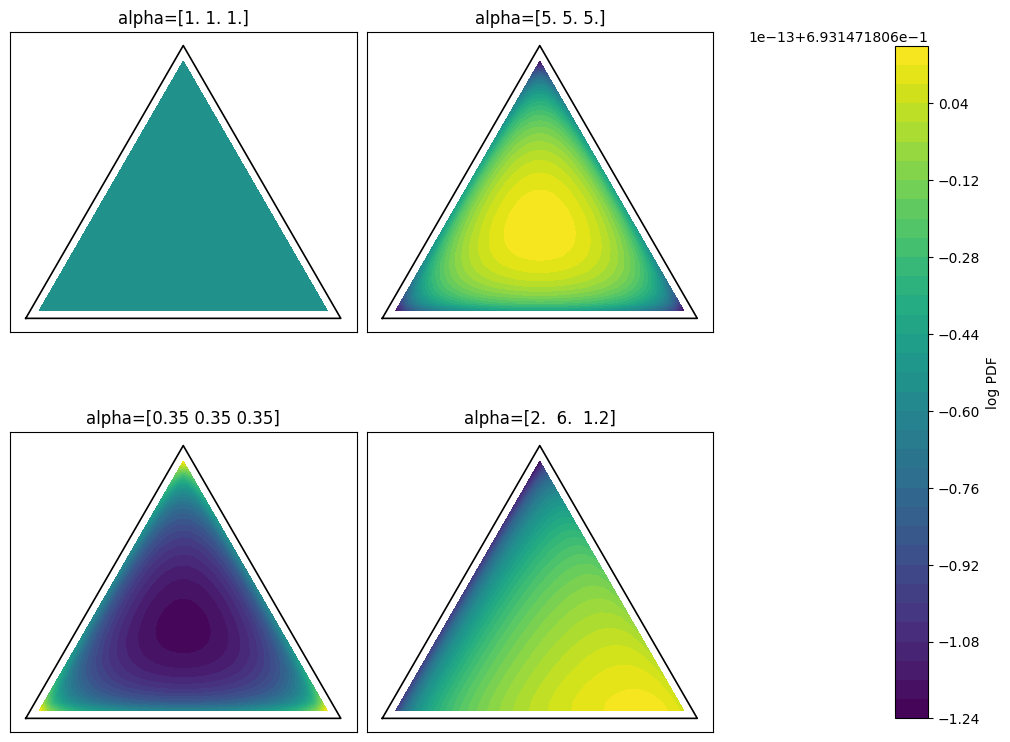

In [5]:
# Shape changes on the 2-simplex (K=3)

alphas = [
    np.array([1.0, 1.0, 1.0]),     # uniform
    np.array([5.0, 5.0, 5.0]),     # concentrated around center
    np.array([0.35, 0.35, 0.35]),  # corners/edges (divergent at boundaries)
    np.array([2.0, 6.0, 1.2]),     # asymmetric
]

fig, axes = plt.subplots(2, 2, figsize=(10, 8), constrained_layout=True)
axes = axes.ravel()

mappables = []
for ax, a in zip(axes, alphas):
    min_comp = 1.0 / GRID_N
    m = plot_dirichlet_simplex3(a, ax=ax, grid_n=GRID_N, min_component=min_comp)
    ax.set_title(f"alpha={a}")
    mappables.append(m)

# One shared colorbar (log-density scale)
cb = fig.colorbar(mappables[0], ax=axes, shrink=0.85)
cb.set_label("log PDF")

plt.show()


In [6]:
# MLE demo on synthetic data
alpha_true = np.array([1.8, 3.2, 5.0])
X = sample_dirichlet_numpy(alpha_true, size=8_000 if FAST_RUN else 40_000, rng=rng)

alpha_hat, opt = dirichlet_fit_mle(X)

print('alpha_true:', alpha_true)
print('alpha_hat: ', np.round(alpha_hat, 4))
print('optimizer success:', opt.success)
print('final nll:', opt.fun)


alpha_true: [1.8 3.2 5. ]
alpha_hat:  [1.8104 3.2148 5.0558]
optimizer success: True
final nll: -12039.241319728375


In [7]:
alpha = np.array([0.7, 1.5, 2.2])
X = sample_dirichlet_numpy(alpha, size=5, rng=rng)

print('samples:')
print(X)
print()
print('row sums:', X.sum(axis=1))


samples:
[[0.0629 0.1306 0.8066]
 [0.0858 0.867  0.0472]
 [0.2672 0.7132 0.0196]
 [0.003  0.7872 0.2098]
 [0.097  0.3468 0.5562]]

row sums: [1. 1. 1. 1. 1.]


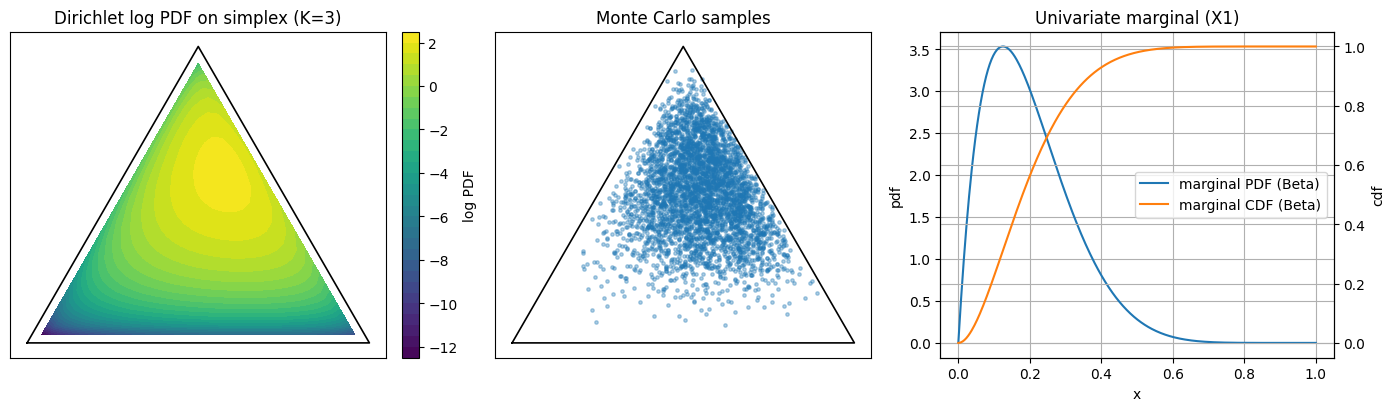

In [8]:
alpha = np.array([2.0, 3.0, 5.0])
rv = stats.dirichlet(alpha)

# 1) PDF over the 2-simplex (K=3)
fig, axes = plt.subplots(1, 3, figsize=(14, 4), constrained_layout=True)

m = plot_dirichlet_simplex3(alpha, ax=axes[0], grid_n=GRID_N, min_component=1.0 / GRID_N)
axes[0].set_title('Dirichlet log PDF on simplex (K=3)')
cb = fig.colorbar(m, ax=axes[0], fraction=0.046, pad=0.04)
cb.set_label('log PDF')

# 2) Monte Carlo samples
samps = rv.rvs(size=4_000 if FAST_RUN else 20_000, random_state=rng)
xy = simplex3_to_xy(samps)
axes[1].scatter(xy[:, 0], xy[:, 1], s=6, alpha=0.35)
plot_simplex3_outline(axes[1])
axes[1].set_title('Monte Carlo samples')

# 3) Marginal PDF and CDF (component 1)
a = alpha[0]
b = alpha.sum() - alpha[0]
xs = np.linspace(0, 1, 400)

axes[2].plot(xs, stats.beta(a, b).pdf(xs), label='marginal PDF (Beta)')
axes[2].set_xlabel('x')
axes[2].set_ylabel('pdf')

ax2 = axes[2].twinx()
ax2.plot(xs, stats.beta(a, b).cdf(xs), color='tab:orange', label='marginal CDF (Beta)')
ax2.set_ylabel('cdf')

lines1, labels1 = axes[2].get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
axes[2].legend(lines1 + lines2, labels1 + labels2, loc='center right')
axes[2].set_title('Univariate marginal (X1)')

plt.show()


In [9]:
alpha = np.array([1.4, 2.1, 3.7])
rv = stats.dirichlet(alpha)

x = np.array([0.25, 0.5, 0.25])

print('pdf:', rv.pdf(x))
print('logpdf:', rv.logpdf(x))
print('mean:', rv.mean())
print('var:', rv.var())
print('entropy:', rv.entropy())

# Fit alpha on synthetic samples
X = rv.rvs(size=6_000 if FAST_RUN else 30_000, random_state=rng)
alpha_hat, opt = dirichlet_fit_mle(X)
print()
print('alpha true:', alpha)
print('alpha hat :', np.round(alpha_hat, 4))


pdf: 1.7211221842088231
logpdf: 0.5429765107632374
mean: [0.1944 0.2917 0.5139]
var: [0.0191 0.0252 0.0305]
entropy: -1.270846226905952

alpha true: [1.4 2.1 3.7]
alpha hat : [1.4036 2.082  3.6722]


In [10]:
# Example: Bayesian updating + a posterior probability "test"

prior_alpha = np.array([1.0, 1.0, 1.0])  # uniform prior on simplex
counts = np.array([12, 5, 3])
posterior_alpha = prior_alpha + counts

rv_post = stats.dirichlet(posterior_alpha)

print('prior alpha:    ', prior_alpha)
print('observed counts:', counts)
print('posterior alpha:', posterior_alpha)

print()
print('posterior mean:', np.round(rv_post.mean(), 4))
print('posterior var :', np.round(rv_post.var(), 6))

# Posterior probability that category 1 is more likely than category 2
post_samples = rv_post.rvs(size=50_000 if FAST_RUN else 250_000, random_state=rng)
p_gt = (post_samples[:, 0] > post_samples[:, 1]).mean()
print()
print('P(p1 > p2 | data) ≈', round(float(p_gt), 4))

# Posterior predictive simulation for 20 future trials
n_future = 20
p_draw = rv_post.rvs(size=1, random_state=rng)[0]
future_counts = rng.multinomial(n_future, p_draw)
print()
print('p_draw (one posterior draw):', np.round(p_draw, 4))
print('one predictive sample (n=20):', future_counts)


prior alpha:     [1. 1. 1.]
observed counts: [12  5  3]
posterior alpha: [13.  6.  4.]

posterior mean: [0.5652 0.2609 0.1739]
posterior var : [0.0102 0.008  0.006 ]

P(p1 > p2 | data) ≈ 0.9525

p_draw (one posterior draw): [0.6581 0.2254 0.1164]
one predictive sample (n=20): [14  4  2]
